# Deep Clustering for Financial Market Segmentation
## A deep learning approach for credit card customer clustering

In [1]:
from time import time
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
np.random.seed(10)

In [3]:
data = pd.read_csv('./data/CC_GENRAL.csv')

In [4]:
data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [5]:
data_x = data.drop(['CUST_ID'], axis=1)

In [6]:
data_x.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [7]:
numeric_columns = data_x.columns.values.tolist()

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
data_x[numeric_columns] = scaler.fit_transform(data_x[numeric_columns])

In [9]:
data_x.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,0.002148,0.818182,0.001945,0.000000,0.00424,0.000000,0.166667,0.000000,0.083333,0.000000,0.00000,0.005587,0.031720,0.003979,0.001826,0.000000,1.0
1,0.168169,0.909091,0.000000,0.000000,0.00000,0.136685,0.000000,0.000000,0.000000,0.166667,0.03252,0.000000,0.232053,0.080893,0.014034,0.222222,1.0
2,0.131026,1.000000,0.015766,0.018968,0.00000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.033520,0.248748,0.012264,0.008210,0.000000,1.0
3,0.087521,0.636364,0.030567,0.036775,0.00000,0.004366,0.083333,0.083333,0.000000,0.055555,0.00813,0.002793,0.248748,0.000000,NaN,0.000000,1.0
4,0.042940,1.000000,0.000326,0.000393,0.00000,0.000000,0.083333,0.083333,0.000000,0.000000,0.00000,0.002793,0.038397,0.013374,0.003204,0.000000,1.0


In [10]:
data_x.isnull().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [11]:
data_x.fillna(0, inplace=True)

In [12]:
data_x.isnull().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

In [13]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected symmetric auto-encoder model.
  
    dims: list of the sizes of layers of encoder like [500, 500, 2000, 10]. 
          dims[0] is input dim, dims[-1] is size of the latent hidden layer.

    act: activation function
    
    return:
        (autoencoder_model, encoder_model): Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    
    input_data = Input(shape=(dims[0],), name='input')
    x = input_data
    
    # internal layers of encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # latent hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)

    x = encoded
    # internal layers of decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # decoder output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    
    decoded = x
    
    autoencoder_model = Model(inputs=input_data, outputs=decoded, name='autoencoder')
    encoder_model     = Model(inputs=input_data, outputs=encoded, name='encoder')
    
    return autoencoder_model, encoder_model


In [14]:
data_x.dtypes

BALANCE                             float64
BALANCE_FREQUENCY                   float64
PURCHASES                           float64
ONEOFF_PURCHASES                    float64
INSTALLMENTS_PURCHASES              float64
CASH_ADVANCE                        float64
PURCHASES_FREQUENCY                 float64
ONEOFF_PURCHASES_FREQUENCY          float64
PURCHASES_INSTALLMENTS_FREQUENCY    float64
CASH_ADVANCE_FREQUENCY              float64
CASH_ADVANCE_TRX                    float64
PURCHASES_TRX                       float64
CREDIT_LIMIT                        float64
PAYMENTS                            float64
MINIMUM_PAYMENTS                    float64
PRC_FULL_PAYMENT                    float64
TENURE                              float64
dtype: object

In [15]:
x = data_x.values
x.shape

(8950, 17)

In [16]:
n_clusters = 3 # 3 - 0.291, 4 - 0.280, 5 - 0.228, 6 - 0.227, 10 - 0.192
n_epochs   = 100
batch_size = 128

In [17]:
kmeans = KMeans(n_clusters=n_clusters, n_jobs=4)
y_pred_kmeans = kmeans.fit_predict(x)

In [18]:
dims = [x.shape[-1], 500, 500, 2000, 10] 
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = n_epochs
batch_size = batch_size
save_dir = './results'

In [19]:
dims

[17, 500, 500, 2000, 10]

In [20]:
autoencoder, encoder = autoencoder(dims, init=init)

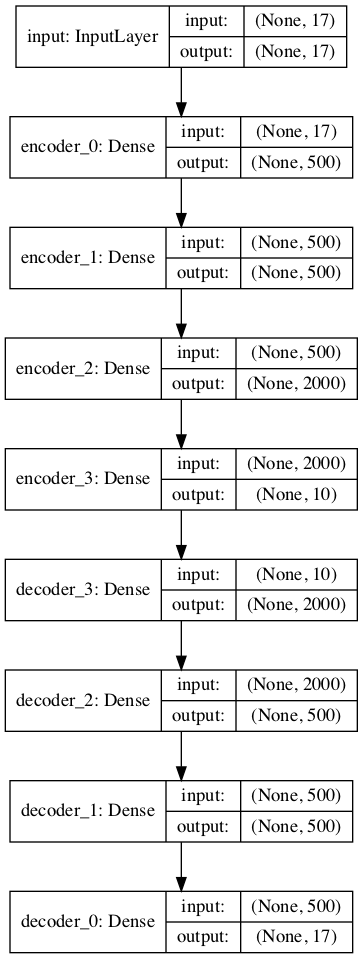

In [21]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png') 

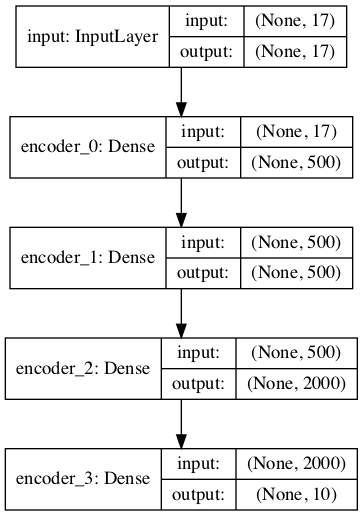

In [22]:
from keras.utils import plot_model
plot_model(encoder, to_file='encoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='encoder.png') 

In [23]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs)
autoencoder.save_weights(save_dir + '/ae_weights.h5')

Epoch 1/100
8950/8950 [==============================] - 2s 242us/step - loss: 0.0341
Epoch 2/100
8950/8950 [==============================] - 2s 231us/step - loss: 0.0155
Epoch 3/100
8950/8950 [==============================] - 2s 230us/step - loss: 0.0067
Epoch 4/100
8950/8950 [==============================] - 2s 230us/step - loss: 0.0035
Epoch 5/100
8950/8950 [==============================] - 2s 231us/step - loss: 0.0021
Epoch 6/100
8950/8950 [==============================] - 2s 230us/step - loss: 0.0017
Epoch 7/100
8950/8950 [==============================] - 2s 226us/step - loss: 0.0013
Epoch 8/100
8950/8950 [==============================] - 2s 221us/step - loss: 0.0011
Epoch 9/100
8950/8950 [==============================] - 2s 224us/step - loss: 9.8839e-04
Epoch 10/100
8950/8950 [==============================] - 2s 224us/step - loss: 9.1123e-04
Epoch 11/100
8950/8950 [==============================] - 2s 219us/step - loss: 8.1957e-04
Epoch 12/100
8950/8950 [================

8950/8950 [==============================] - 2s 235us/step - loss: 9.0866e-05
Epoch 92/100
8950/8950 [==============================] - 2s 235us/step - loss: 9.2167e-05
Epoch 93/100
8950/8950 [==============================] - ETA: 0s - loss: 8.9535e-0 - 2s 234us/step - loss: 8.9399e-05
Epoch 94/100
8950/8950 [==============================] - 2s 229us/step - loss: 8.4975e-05
Epoch 95/100
8950/8950 [==============================] - 2s 230us/step - loss: 8.7982e-05
Epoch 96/100
8950/8950 [==============================] - 2s 231us/step - loss: 8.6937e-05
Epoch 97/100
8950/8950 [==============================] - 2s 231us/step - loss: 8.6832e-05
Epoch 98/100
8950/8950 [==============================] - 2s 229us/step - loss: 8.5067e-05
Epoch 99/100
8950/8950 [==============================] - 2s 237us/step - loss: 8.3203e-05
Epoch 100/100
8950/8950 [==============================] - 2s 239us/step - loss: 8.3950e-05


In [24]:
autoencoder.save_weights(save_dir + '/ae_weights.h5')

In [25]:
autoencoder.load_weights(save_dir + '/ae_weights.h5')

In [26]:
class ClusteringLayer(Layer):
    '''
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    '''

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(name='clusters', shape=(self.n_clusters, input_dim), initializer='glorot_uniform') 
        
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        ''' 
        student t-distribution, as used in t-SNE algorithm.
        It measures the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
       
        inputs: the variable containing data, shape=(n_samples, n_features)
        
        Return: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        '''
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure all of the values of each sample sum up to 1.
        
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [27]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

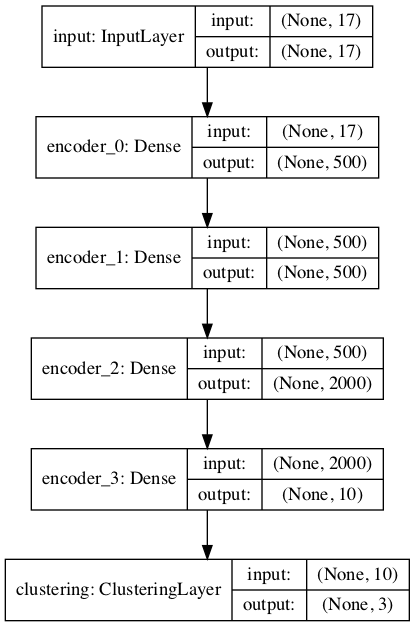

In [28]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 

In [29]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')

In [30]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))

In [31]:
y_pred_last = np.copy(y_pred)

In [32]:
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

## deep clustering

In [33]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [34]:
loss = 0
index = 0
maxiter = 1000 # 8000
update_interval = 100 # 140
index_array = np.arange(x.shape[0])

In [35]:
tol = 0.001 # tolerance threshold to stop training

In [36]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/DEC_model_final.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [37]:
model.load_weights(save_dir + '/DEC_model_final.h5')

In [38]:
# Eval.
q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)

In [39]:
data_all = data_x.copy()

In [40]:
data_all['cluster'] = y_pred

In [41]:
data_all.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,0.002148,0.818182,0.001945,0.000000,0.00424,0.000000,0.166667,0.000000,0.083333,0.000000,0.00000,0.005587,0.031720,0.003979,0.001826,0.000000,1.0,0
1,0.168169,0.909091,0.000000,0.000000,0.00000,0.136685,0.000000,0.000000,0.000000,0.166667,0.03252,0.000000,0.232053,0.080893,0.014034,0.222222,1.0,0
2,0.131026,1.000000,0.015766,0.018968,0.00000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.033520,0.248748,0.012264,0.008210,0.000000,1.0,1
3,0.087521,0.636364,0.030567,0.036775,0.00000,0.004366,0.083333,0.083333,0.000000,0.055555,0.00813,0.002793,0.248748,0.000000,0.000000,0.000000,1.0,0
4,0.042940,1.000000,0.000326,0.000393,0.00000,0.000000,0.083333,0.083333,0.000000,0.000000,0.00000,0.002793,0.038397,0.013374,0.003204,0.000000,1.0,0


In [42]:
data_all['cluster'].value_counts()

0    4129
1    3087
2    1734
Name: cluster, dtype: int64

In [43]:
import numpy as np
from sklearn.manifold import TSNE

x_embedded = TSNE(n_components=2).fit_transform(x)

x_embedded.shape

(8950, 2)

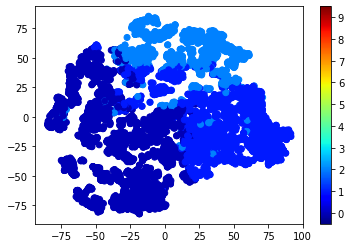

In [44]:
vis_x = x_embedded[:, 0]
vis_y = x_embedded[:, 1]
plt.scatter(vis_x, vis_y, c=y_pred, cmap=plt.cm.get_cmap("jet", 256))
plt.colorbar(ticks=range(256))
plt.clim(-0.5, 9.5)
plt.show()

In [45]:
y_pred_kmeans.shape

(8950,)

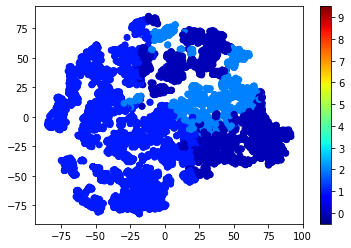

In [46]:
plt.scatter(vis_x, vis_y, c=y_pred_kmeans, cmap=plt.cm.get_cmap("jet", 256))
plt.colorbar(ticks=range(256))
plt.clim(-0.5, 9.5)
plt.show()

In [47]:
# For n_clusters = 3, Kmeans silhouette score is 0.3723536590701517)
# For n_clusters = 4, Kmeans silhouette score is 0.3215079773343314)
# For n_clusters = 10, Kmeans silhouette score is 0.34194939183619716)
from sklearn.metrics import silhouette_score

# centers = kmeans.cluster_centers_
score = silhouette_score (x, y_pred_kmeans, metric='euclidean')
print ("For n_clusters = {}, Kmeans silhouette score is {})".format(n_clusters, score))

For n_clusters = 3, Kmeans silhouette score is 0.372350277731719)


In [48]:
# For n_clusters = 3, Deep clustering silhouette score is 0.29138845064227953)
# For n_clusters = 4, Deep clustering silhouette score is 0.28032271072644543)
# For n_clusters = 10, Deep clustering silhouette score is 0.19216022223500343)
score = silhouette_score (x, y_pred, metric='euclidean')
print ("For n_clusters = {}, Deep clustering silhouette score is {})".format(n_clusters, score))

For n_clusters = 3, Deep clustering silhouette score is 0.3295206157464908)


In [49]:
for num_clusters in range(2,10):
    clusterer = KMeans(n_clusters=num_clusters, n_jobs=4)
    preds = clusterer.fit_predict(x)
    # centers = clusterer.cluster_centers_
    score = silhouette_score (x, preds, metric='euclidean')
    print ("For n_clusters = {}, Kmeans silhouette score is {})".format(num_clusters, score))

For n_clusters = 2, Kmeans silhouette score is 0.38671905661700495)
For n_clusters = 3, Kmeans silhouette score is 0.37239144184726347)
For n_clusters = 4, Kmeans silhouette score is 0.3215104946972683)
For n_clusters = 5, Kmeans silhouette score is 0.3195084713077689)
For n_clusters = 6, Kmeans silhouette score is 0.3300968184834632)
For n_clusters = 7, Kmeans silhouette score is 0.3380116152747751)
For n_clusters = 8, Kmeans silhouette score is 0.32452927132290305)
For n_clusters = 9, Kmeans silhouette score is 0.33427246553434786)


In [50]:
# Need to re-run autoencoder function declaration!!!
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_data = Input(shape=(dims[0],), name='input')
    x = input_data
    
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_data, outputs=decoded, name='AE'), Model(inputs=input_data, outputs=encoded, name='encoder')


In [51]:
autoencoder, encoder = autoencoder(dims, init=init)
autoencoder.load_weights(save_dir + '/ae_weights.h5')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=[clustering_layer, autoencoder.output])

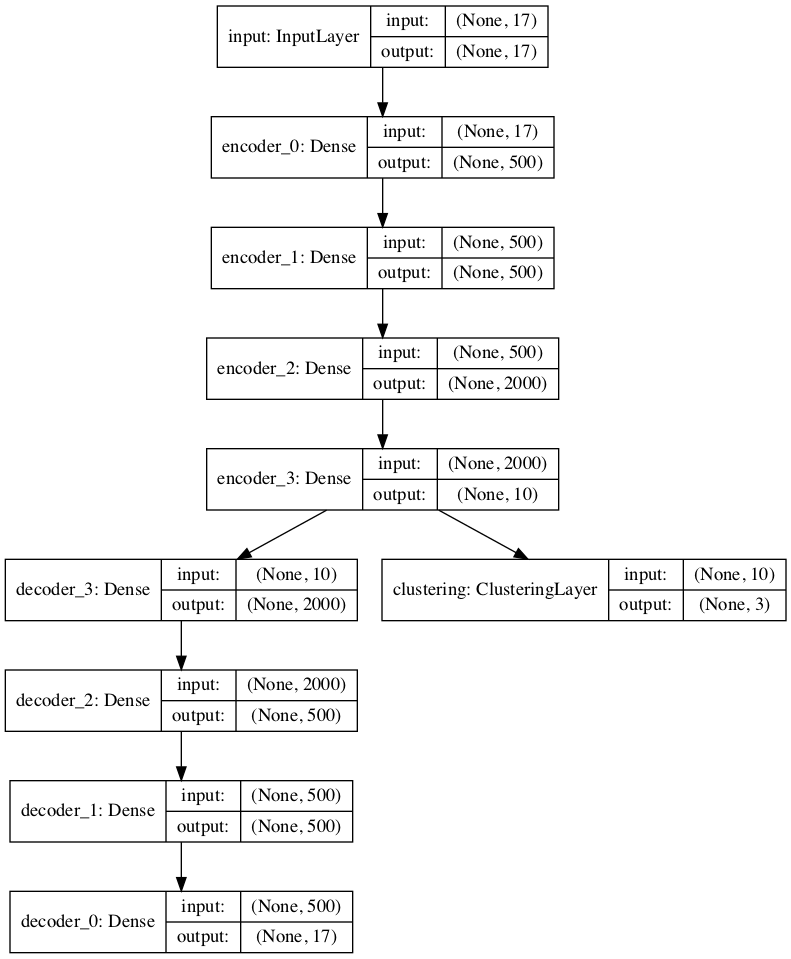

In [52]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 

In [53]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

In [54]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer=pretrain_optimizer)

In [55]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/b_DEC_model_final.h5')

In [56]:
model.load_weights(save_dir + '/b_DEC_model_final.h5')

In [57]:
# evaluation of model prediction 
q, _ = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)

In [58]:
score = silhouette_score (x, y_pred, metric='euclidean')
print ("For n_clusters = {}, Deep clustering silhouette score is {})".format(n_clusters, score))

For n_clusters = 3, Deep clustering silhouette score is 0.3175766487903548)


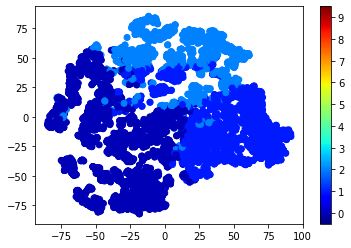

In [59]:
# plt.scatter(vis_x, vis_y, c=y_pred, cmap=plt.cm.get_cmap("jet", n_clusters))
# plt.colorbar(ticks=range(n_clusters))
plt.scatter(vis_x, vis_y, c=y_pred, cmap=plt.cm.get_cmap("jet", 256))
plt.colorbar(ticks=range(256))
plt.clim(-0.5, 9.5)
plt.show()

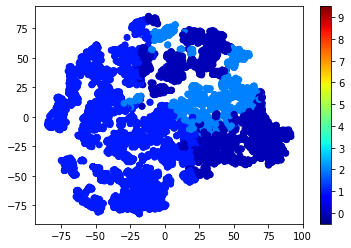

In [60]:
plt.scatter(vis_x, vis_y, c=y_pred_kmeans, cmap=plt.cm.get_cmap("jet", 256))
plt.colorbar(ticks=range(256))
plt.clim(-0.5, 9.5)
plt.show()

In [61]:
data_all['cluster'] = y_pred

In [62]:
data_all['cluster'].value_counts()

0    4026
1    2896
2    2028
Name: cluster, dtype: int64

In [63]:
data_cluster_0 = data_all[data_all['cluster'] == 0]

In [64]:
data_cluster_0.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
count,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.000000,4026.0
mean,0.099117,0.865668,0.005549,0.006152,0.000956,0.031088,0.112747,0.090667,0.022381,0.136174,0.039025,0.006700,0.134916,0.027988,0.011524,0.019485,0.906317,0.0
std,0.108420,0.253920,0.016297,0.019421,0.004488,0.049126,0.156246,0.147649,0.061454,0.143240,0.062258,0.020164,0.109719,0.047557,0.029293,0.054724,0.235599,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.022997,0.875000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048414,0.006387,0.002520,0.000000,1.000000,0.0
50%,0.064679,1.000000,0.000258,0.000000,0.000000,0.011085,0.083333,0.000000,0.000000,0.111111,0.016260,0.002793,0.098497,0.013303,0.005422,0.000000,1.000000,0.0
75%,0.133954,1.000000,0.005098,0.005230,0.000000,0.042028,0.166667,0.111111,0.000000,0.222222,0.048780,0.008380,0.198664,0.029561,0.011706,0.000000,1.000000,0.0
max,0.801245,1.000000,0.450693,0.542225,0.133333,0.555698,0.750000,0.750000,0.333333,1.000000,1.000000,0.863128,0.766277,1.000000,0.798778,0.500000,1.000000,0.0


In [65]:
data_cluster_1 = data_all[data_all['cluster'] == 1]
data_cluster_1.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
count,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.000000,2896.0
mean,0.104522,0.939751,0.032428,0.019466,0.035433,0.017720,0.840065,0.256551,0.744652,0.076492,0.023935,0.076194,0.157844,0.038493,0.015580,0.029401,0.935716,1.0
std,0.125719,0.173226,0.049481,0.046098,0.048759,0.044966,0.195348,0.312682,0.250383,0.130125,0.056569,0.083918,0.129218,0.059795,0.040074,0.065184,0.201895,0.0
min,0.000000,0.000000,0.000245,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008347,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.019768,1.000000,0.007935,0.000000,0.010622,0.000000,0.666667,0.000000,0.500000,0.000000,0.000000,0.030726,0.048414,0.009441,0.002521,0.000000,1.000000,1.0
50%,0.061643,1.000000,0.017451,0.004167,0.020755,0.000000,0.916667,0.083333,0.833333,0.000000,0.000000,0.047486,0.115192,0.021322,0.006273,0.000000,1.000000,1.0
75%,0.138796,1.000000,0.039065,0.023180,0.042709,0.017876,1.000000,0.416667,1.000000,0.111111,0.024390,0.092179,0.232053,0.043483,0.015066,0.000000,1.000000,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.666667,1.000000,0.969274,1.000000,0.925261,1.000000,0.333333,1.000000,1.0


In [66]:
data_cluster_2 = data_all[data_all['cluster'] == 2]
data_cluster_2.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
count,2028.000000,2028.000000,2028.000000,2028.000000,2028.000000,2028.000000,2028.000000,2028.000000,2028.000000,2028.000000,2028.000000,2028.000000,2028.000000,2028.000000,2028.000000,2028.000000,2028.000000,2028.0
mean,0.016538,0.811082,0.032958,0.024133,0.028131,0.004626,0.740576,0.347139,0.500541,0.018049,0.004915,0.059227,0.161589,0.040268,0.003044,0.597710,0.922748,2.0
std,0.035204,0.258199,0.059617,0.057190,0.050823,0.023946,0.296109,0.400094,0.378022,0.063106,0.023184,0.077338,0.129458,0.068161,0.005947,0.332581,0.224698,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008347,0.000000,0.000000,0.000000,0.000000,2.0
25%,0.001636,0.636364,0.006301,0.000000,0.002339,0.000000,0.500000,0.000000,0.083333,0.000000,0.000000,0.019553,0.065109,0.008359,0.001615,0.333333,1.000000,2.0
50%,0.004785,1.000000,0.015294,0.003697,0.013333,0.000000,0.833333,0.090909,0.500000,0.000000,0.000000,0.033520,0.131886,0.019854,0.002140,0.600000,1.000000,2.0
75%,0.013982,1.000000,0.037572,0.025574,0.033333,0.000000,1.000000,0.750000,0.888889,0.000000,0.000000,0.067039,0.232053,0.044475,0.002454,0.916667,1.000000,2.0
max,0.339274,1.000000,0.816498,0.836278,0.688764,0.579086,1.000000,1.000000,1.000000,0.611111,0.349593,1.000000,1.000000,0.706675,0.155142,1.000000,1.000000,2.0


In [67]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)

x_pca.shape

(8950, 2)

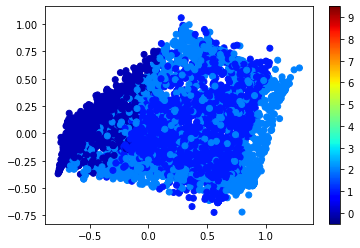

In [68]:
vis_x = x_pca[:, 0]
vis_y = x_pca[:, 1]
plt.scatter(vis_x, vis_y, c=y_pred, cmap=plt.cm.get_cmap("jet", 256))
plt.colorbar(ticks=range(256))
plt.clim(-0.5, 9.5)
plt.show()